C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set

Mean Absolute Error (MAE): 214947.47
Root Mean Squared Error (RMSE): 260157.05
Mean Absolute Percentage Error (MAPE): 15.06%
R-squared (R²): 0.18
Precisão do Modelo: 84.94%
SMAPE: 15.63%
AIC: 768.81
BIC: 787.46
Ljung-Box Test P-value: 0.1769


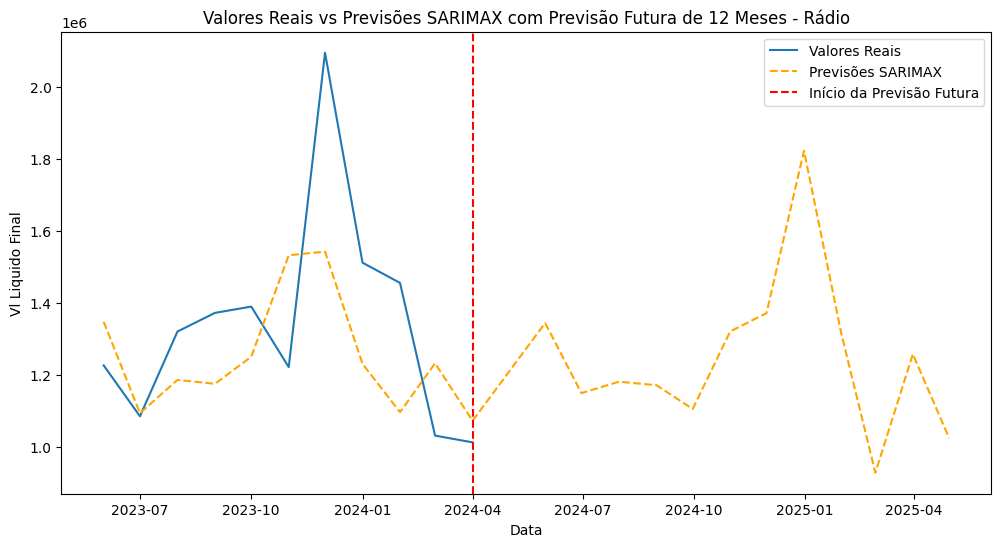

<Figure size 1200x600 with 0 Axes>

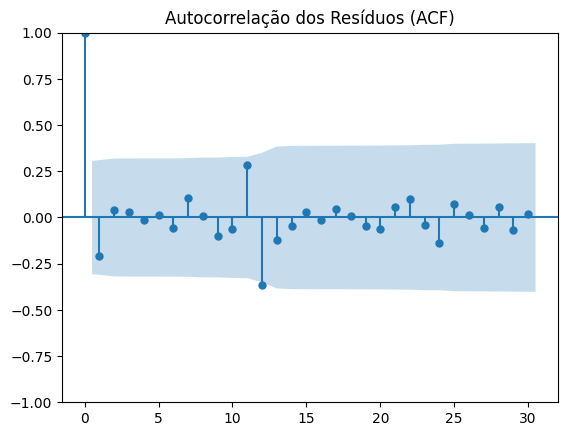

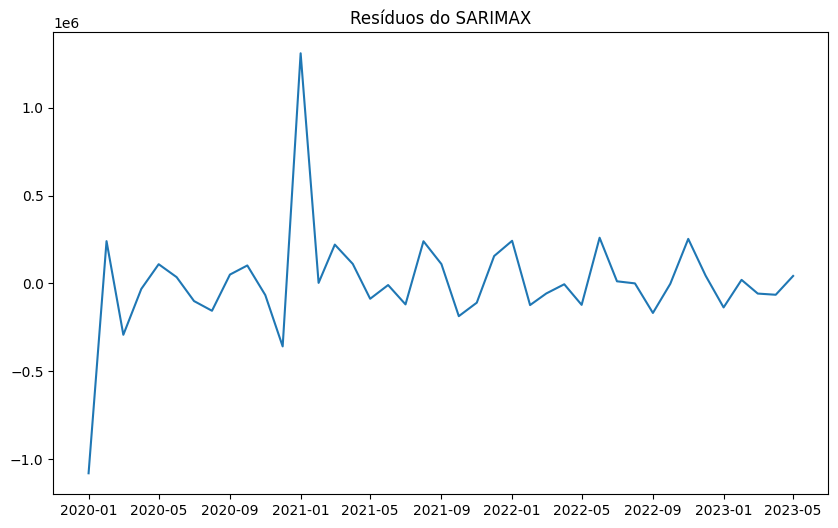

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Carregar o DataFrame de Rádio
df_radio = pd.read_csv('../../df_radio.csv')

# Define a coluna 'Data' como índice e converte para datetime
df_radio['Data'] = pd.to_datetime(df_radio['Data'])  # Converte a coluna Data para datetime
df_radio.set_index('Data', inplace=True)

# Remover variáveis exógenas menos relevantes e sem lags
X = df_radio.drop(columns=['Vl Liquido Final', 'Vl Bruto', 'VL Tabela', 'Contratos', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR', 'PMC - Número-índice (2022=100) (Número-índice)/ ES'])
y = df_radio['Vl Liquido Final']

# Garantir que os índices de X e y estejam alinhados
X, y = X.align(y, join='inner', axis=0)

# Divida os dados em treinamento e teste (85% para treinamento, 15% para teste)
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Função para calcular o SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Treinando o modelo SARIMAX com os melhores parâmetros recomendados pelo Optuna
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)
result = model.fit()

# Previsão no conjunto de teste
forecast_test = model_fit.forecast(steps=len(test_y), exog=test_X)

# Previsão futura de 12 meses
future_steps = 12
future_dates = pd.date_range(start=pd.to_datetime(test_y.index[-1]) + pd.DateOffset(months=1), periods=future_steps, freq='M')
forecast_future = model_fit.forecast(steps=future_steps, exog=X.iloc[-future_steps:])

# Combine previsões de teste e futuras
all_forecast = np.concatenate([forecast_test, forecast_future])
all_dates = test_y.index.append(future_dates)

# Calcule as métricas de avaliação
mae = mean_absolute_error(test_y, forecast_test)
rmse = np.sqrt(mean_squared_error(test_y, forecast_test))
mape = np.mean(np.abs((test_y - forecast_test) / test_y)) * 100
r2 = r2_score(test_y, forecast_test)
precision = 100 - mape
smape_value = smape(test_y, forecast_test)
aic = model_fit.aic
bic = model_fit.bic
ljung_box_test = acorr_ljungbox(model_fit.resid, lags=[12], return_df=True)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")
print(f"Precisão do Modelo: {precision:.2f}%")
print(f"SMAPE: {smape_value:.2f}%")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"Ljung-Box Test P-value: {ljung_box_test['lb_pvalue'].values[0]:.4f}")

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(all_dates, all_forecast, label='Previsões SARIMAX', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Vl Liquido Final')
plt.title(f'Valores Reais vs Previsões SARIMAX com Previsão Futura de 12 Meses - Rádio')
plt.legend()
plt.show()

# Plot de autocorrelação dos resíduos (ACF)
plt.figure(figsize=(12, 6))
plot_acf(model_fit.resid, lags=30)
plt.title('Autocorrelação dos Resíduos (ACF)')
plt.show()

# Plot dos resíduos
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Resíduos do SARIMAX')
plt.show()







In [33]:
# import optuna
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_percentage_error

# # Exemplo de dados - substitua pelos seus dados reais
# data = pd.Series([...])  # Substitua pelos seus dados

# # Verifique e ajuste os dados
# data = pd.to_numeric(data, errors='coerce')
# data = data.dropna()  # Remova valores nulos

# # Divida os dados em treino e teste
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# # Função de objetivo para otimização com Optuna
# def objective(trial):
#     # Limitar a busca de p, d, q em torno de 1
#     p = trial.suggest_int('p', 0, 2)  
#     d = trial.suggest_int('d', 0, 1)  
#     q = trial.suggest_int('q', 0, 2)
#     P = trial.suggest_int('P', 0, 2)
#     D = trial.suggest_int('D', 0, 1)
#     Q = trial.suggest_int('Q', 0, 2)
#     m = 12  # Fixa sazonalidade para anual

#     try:
#         model = SARIMAX(train_y, exog=train_X, order=(p, d, q), seasonal_order=(P, D, Q, m))
#         model_fit = model.fit(disp=False)
#         predictions = model_fit.forecast(steps=len(test_y), exog=test_X)
#         mape = mean_absolute_percentage_error(test_y, predictions)
#         return mape
#     except:
#         return float('inf')

# # Criar o estudo de otimização
# study = optuna.create_study(direction='minimize')  # Queremos minimizar o MAPE
# study.optimize(objective, n_trials=50)  # Tenta 50 combinações de hiperparâmetros

# # Exibir os melhores parâmetros e resultado
# print(f"Melhores Parâmetros: {study.best_params}")
# print(f"Melhor MAPE: {study.best_value}")


[I 2024-09-20 11:39:23,462] A new study created in memory with name: no-name-6879e6c7-7040-49be-ac8a-358d8384adde
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
[I 2024-09-20 11:39:26,160] Trial 0 finished with value: 0.12502888385747538 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2}. Best is trial 0 with value: 0.12502888385747538.
c:\Python312\Lib\site-pa

Melhores Parâmetros: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}
Melhor MAPE: 0.11031725676689051
